In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import learning_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")
from itertools import product
from sklearn.metrics import accuracy_score

In [28]:
df = pd.read_csv('heart.csv')

x = df[['restecg', 'oldpeak']]
y = df['target']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

dt = DecisionTreeClassifier(random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

In [29]:
# Hard Voting
voting_hard = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb',xgb)],
    voting='hard'
)
voting_hard.fit(xtrain, ytrain)
hard_acc = voting_hard.score(xtest, ytest)

# Soft Voting
voting_soft = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb',xgb)],
    voting='soft'
)
voting_soft.fit(xtrain, ytrain)
soft_acc = voting_soft.score(xtest, ytest)

print("Hard Voting Accuracy:", hard_acc)
print("Soft Voting Accuracy:", soft_acc)

Hard Voting Accuracy: 0.7804878048780488
Soft Voting Accuracy: 0.7707317073170732


In [30]:
# try different weight combinations (each weight bw 1 and 3)
weights_list = list(product([1,2,3], repeat=4))

best_acc = 0
best_weights = None

for weights in weights_list:
    voting_soft_w = VotingClassifier(
        estimators=[('dt', dt), ('knn', knn), ('rf', rf), ('xgb', xgb)],
        voting='soft',
        weights=weights
    )
    voting_soft_w.fit(xtrain, ytrain)
    acc = voting_soft_w.score(xtest, ytest)

    if acc > best_acc:
        best_acc = acc
        best_weights = weights

print(f"Best Weights: {best_weights}")
print(f"Best Accuracy: {best_acc:.4f}")

Best Weights: (1, 1, 3, 3)
Best Accuracy: 0.7854


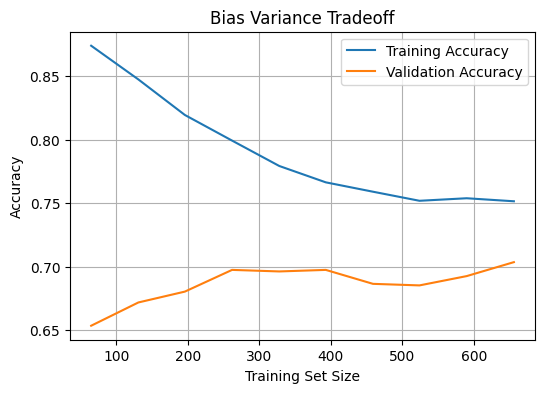

In [31]:
train_sizes, train_scores, test_scores = learning_curve(
    voting_soft, xtrain, ytrain,
    cv = 5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state = 0,
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.title('Bias Variance Tradeoff')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()